# Analysis of Npy2r expression neurons in Usoskin *et al* and Li *et al* DRG scRNAseq experiment

This analysis is part of Ma and Gao *et al* 2018. Several datasets has been produced using scRNAseq on DRG tissue, here we will analyse cells from Li *et al* (GEO accession: **GSE63576**) and Usoskin *et al* (**GSE59739**).

We want to investigate only Npy2r expressing neurons, with relation to predefined cell types (Usoskin), and to map these cell types onto Li *et al* data, we will use Mutual nearest neighbour (MNN) algorithm (*Haghverdi et al. (2018), Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors, Nature Biotechnology.*) to make the datasets comparable, then train a classifier (*Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.*) to predict celltype on Li *et al* cells. 

In [1]:
import pandas as pd
import scanpy.api as sc
import scipy as sp
import numpy as np
import matplotlib
#Makes the text in figures editable in Illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sc.logging.print_versions()

C:\Users\jonja158\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==0+unknown anndata==0.6.10 numpy==1.15.0 scipy==1.0.0 pandas==0.23.3 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1+4.bed07760 louvain==0.6.1 


## Loading data
We start by importin Usoskin *et al* dataset and load it into a anndata object. We further import the meta data and append that to adata. We remove all unclassified neruons by only selecting the cell types: 'NP1', 'TH', 'NF5', 'NF2', 'NF3', 'NP2', 'PEP2', 'NF4', 'PEP1', 'NF1', 'NP3'. We then logaritmize the molecule reads.

In [2]:
#Load Count matrix
uso_data =pd.read_csv("Data/RPM_table.csv", index_col=0, sep = ";", decimal=",")
adata_u = sc.AnnData(uso_data.values.T)
adata_u.obs_names = uso_data.columns
adata_u.var_names = uso_data.index

In [3]:
#Load Meta data
meta = pd.read_csv("Data/metadata_cells.csv", sep = ";", index_col="Sample ID")
adata_u.obs = meta
good_cells = ["NP1", 'TH', 'NF5', 'NF2', 'NF3', 'NP2', 'PEP2', 'NF4', 'PEP1', 'NF1', 'NP3']
keep = [True if cell_type in good_cells else False for cell_type in adata_u.obs["Level 3"]]
adata_u = adata_u[keep]

In [4]:
#Normalize and save raw
sc.pp.normalize_per_cell(adata_u, counts_per_cell_after= 20000)
#sc.pp.normalize_per_cell(adata_u)
adata_u.raw = sc.pp.log1p(adata_u, copy=True)
sc.pp.log1p(adata_u)

Next we load Li *et al* data and logaritmize the reads.

In [5]:
li_data = pd.read_csv("Data/GSE63576_DRG_neurons_RNA_Seq.txt.gz", sep = "\\t", index_col = 0)
adata_l = sc.AnnData(li_data.values.T)
adata_l.obs_names = li_data.columns
adata_l.var_names = li_data.index

C:\Users\jonja158\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [6]:
sc.pp.normalize_per_cell(adata_l, counts_per_cell_after= 20000)
#sc.pp.normalize_per_cell(adata_l)
adata_l.raw = sc.pp.log1p(adata_l, copy=True)
sc.pp.log1p(adata_l)

## Merging of datasets
After MNN transformation of the datasets, it is not recomended to investigate gene expression levels. So here we save a complete and unmodified merge of the datasets that we can return to later and add the detected cell types to. Using "outer" join, genes not expressed, and hence not included in the dataset are assumed to have expression 0 in all cells.

In [7]:
#here we create a merge version of Usoskin and Li datasets which implies 0 expression for genes not shared between the datasets.
#outer join keeps genes from both datasets
merge = adata_u.concatenate(adata_l, batch_categories=["Usoskin", "Li"], join="outer")

#Joining designates NaN instead of 0. here we change all NaN in the X matrix to 0's
merge.X = np.nan_to_num(merge.X)
print((merge.obs["batch"] == "Usoskin").sum(), "cells comes from Usoskin dataset")
print((merge.obs["batch"] == "Li").sum(), "cells comes from Li dataset")

622 cells comes from Usoskin dataset
204 cells comes from Li dataset


C:\Users\jonja158\AppData\Roaming\Python\Python36\site-packages\anndata\base.py:1806: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  obs = pd.concat(out_obss)


We can confirm that the technical variation between the two datasets are prohibitly large for any cell - cell comparisons by plotting the two first PCA componens

... storing 'Content' as categorical
... storing 'Level 1' as categorical
... storing 'Level 2' as categorical
... storing 'Level 3' as categorical
... storing 'Library' as categorical
... storing 'Picking ToC' as categorical
... storing 'Picking sessions' as categorical
... storing 'Sex' as categorical
saving figure to file ./figures/pca_scatter_pre MNN.pdf


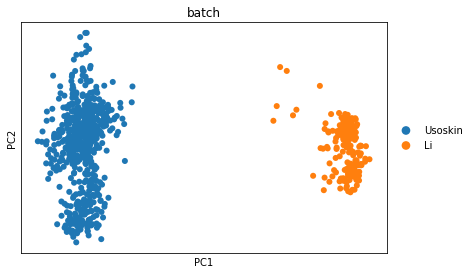

In [8]:
sc.tl.pca(merge)
sc.pl.pca_scatter(merge, color="batch", save = "_pre MNN.pdf")

## MNN
we want to only use the highy variable genes (HVG) shared between the two datasets for MNN transformation. First, HVG are filtered out in both datasets. Making an "inner" join keeps only the genes that are shared. We now have a list of HVG shared between the datasets.

In [9]:
#filter HVG for usoskin and Li dataset
sc.pp.filter_genes_dispersion(adata_u, n_top_genes=1000)
sc.pp.filter_genes_dispersion(adata_l, n_top_genes=1000)

#Merging using inner join will keep only varables that are incommon
merge_inner = adata_u.concatenate(adata_l, batch_categories=["Usoskin", "Li"], join="inner")

#makes a list of shared HVG to use for MNN correction
join_genes = list(merge_inner.var_names)

#Runs the MNN using only shared HVG
mnn = sc.pp.mnn_correct(adata_u[:,join_genes], adata_l[:,join_genes], batch_categories = ["Usoskin", "Li"], save_raw = True)[0]

c:\users\jonja158\github\scanpy\scanpy\preprocessing\simple.py:359: RuntimeWarning: invalid value encountered in greater_equal
  gene_subset = df['dispersion_norm'].values >= disp_cut_off
C:\Users\jonja158\AppData\Roaming\Python\Python36\site-packages\anndata\base.py:1806: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  obs = pd.concat(out_obss)


Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


C:\Users\jonja158\AppData\Roaming\Python\Python36\site-packages\anndata\base.py:1806: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  obs = pd.concat(out_obss)


## Cell type classification
After MNN transformation, we want to confirm that the datasets are no longer the main driver of varance, but that cell types drives the variance. We can do this using PCA again.

... storing 'Content' as categorical
... storing 'Level 1' as categorical
... storing 'Level 2' as categorical
... storing 'Level 3' as categorical
... storing 'Library' as categorical
... storing 'Picking ToC' as categorical
... storing 'Picking sessions' as categorical
... storing 'Sex' as categorical
saving figure to file ./figures/pca_scatter_post MNN.pdf


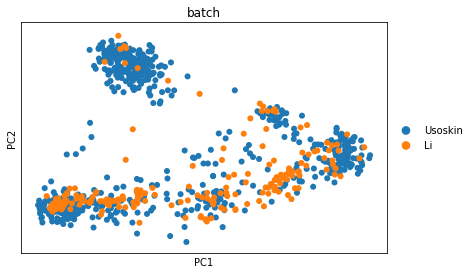

In [10]:
sc.tl.pca(mnn)
sc.pl.pca(mnn, color="batch", save = "_post MNN.pdf")

We can further see using Uniform manifold approximation and projection (UMAP) that Usoskin *et al* cell types indeed repesents the clusters produced, and that Li *et al* cells (**nan**) joins these clusters.

In [11]:
sc.pp.neighbors(mnn, n_neighbors=15)
sc.tl.louvain(mnn)
sc.tl.umap(mnn, random_state=3)

In [12]:
#Sets a new color scheme for the different level 3 cell types
import seaborn as sns
import matplotlib.colors
NF_color = sns.cubehelix_palette(n_colors=5, start=2, rot=0.1, gamma=0.7, light=0.6, dark=0.25, hue=1)
NP_color = sns.cubehelix_palette(n_colors=3, start=2.5, rot=0.1, gamma=0.7, light=0.6, dark=0.25, hue=1)
PEP_color = sns.cubehelix_palette(n_colors=2, start=4, rot=0.1, gamma=0.7, light=0.6, dark=0.25, hue=1)
TH_color = ["lightgrey"]
level_3_color = NF_color + NP_color + PEP_color + TH_color + ["red"]
level_3_color

[[0.5162451817565703, 0.7981301372254046, 0.6690694584967207],
 [0.4266163127733914, 0.7379981297940461, 0.5813516328306669],
 [0.3392250297263762, 0.6658291846880431, 0.4858262763985476],
 [0.2617458326175084, 0.5858183086057607, 0.3919662825261784],
 [0.19013055534958329, 0.49199924633761716, 0.29681591932464446],
 [0.5707118165298367, 0.7344818176982066, 0.8619121779183108],
 [0.3795314568916205, 0.6013832745017109, 0.7215658416424379],
 [0.20582163571504947, 0.44122891956331295, 0.5263371175380758],
 [0.8280245642990223, 0.6642545631306521, 0.5368242029105483],
 [0.5541158211405014, 0.3187085372922378, 0.2336003393174752],
 'lightgrey',
 'red']

saving figure to file ./figures/umap_pre_lsvm_prediction.pdf


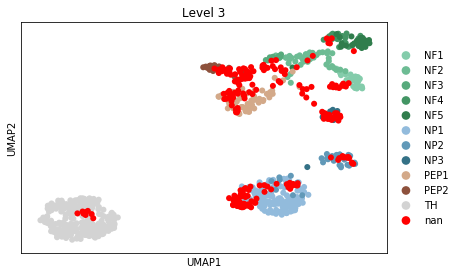

In [13]:
sc.pl.umap(mnn, color=["Level 3"], palette = level_3_color, save = "_pre_lsvm_prediction.pdf")

Lets train a classifier (LinearSVC) using the Usoskin count matrix as predictor varables, and the cell types as lables. 

In [14]:
train_X = mnn.X[mnn.obs["batch"] == "Usoskin", :]
train_y =mnn.obs["Level 3"][mnn.obs["batch"] == "Usoskin"].values
test_X =  mnn.X[mnn.obs["batch"] == "Li", :]


In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

#evaluating linearSVC
clf_lsvm = LinearSVC(dual=False)
clf_lsvm.fit(train_X, train_y)
print(clf_lsvm.score(train_X, train_y))

#using cross_val_score to estimate the overfitting and accuracy (Not working 20180917)
#cross_val_score(estimator=clf_lsvm, X=train_X, y=train_y)

#evaluating Kneigbors
clf_knc = KNeighborsClassifier(n_neighbors=5)
clf_knc.fit(train_X, train_y)
print(clf_knc.score(train_X, train_y))


0.9887459807073955
0.9485530546623794


The most accurate classifier is lsvm

In [16]:
labels = clf_lsvm.predict(test_X)
#prob = clf_knc.predict_proba(mnn.X)
prob = clf_lsvm.decision_function(mnn.X)


In [17]:
import numpy as np

prob = np.max(prob, axis = 1)

In [18]:
mnn.obs["Level 3"][mnn.obs["batch"] == "Li"] = labels
mnn.obs["probability"] = prob

We can now plot our new labels on the Li *et al* cells, and they seem quite well labled. The probability is the confidance of the lable assignment.

saving figure to file ./figures/umap_post_lsvm_prediction.pdf


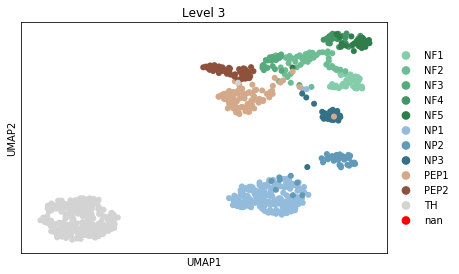

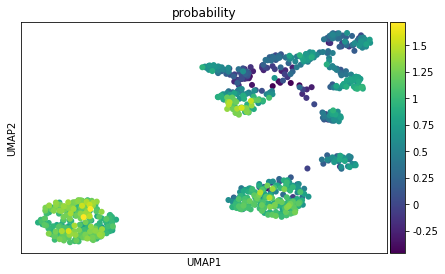

In [19]:
level_3_color
sc.pl.umap(mnn, color=["Level 3"], palette = level_3_color, save="_post_lsvm_prediction.pdf")
sc.pl.umap(mnn, color=["probability"])

#Gene expression analysis on the merge dataset

To analyse gene expression, we will have to go back to the original "outer" join dataset, with the gene expression levels untouched. We can add the labels we just created to that dataset

In [20]:
#Move lables and probalilities to original merge dataset for further expresion analysis
merge.obs["Level 3"] = mnn.obs["Level 3"]
merge.obs["Probability"] = mnn.obs["probability"]

# Analysis of Npy2r expressing neurons
Lets start by looking at the gene expression distibution of *Npy2r*. Here we see that highest expression is around 3 and most cells are at 0. To capture cells that have quite low expression, we will use a cut off of 0.01 expression. this ensures that we get the cells just above 0.

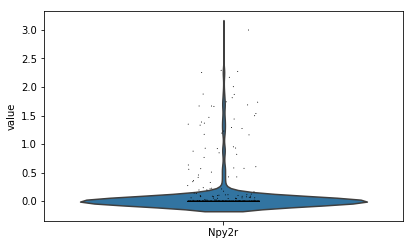

In [21]:
sc.pl.violin(merge, keys="Npy2r")

We expect Npy2r to be expressed in more than one cell type. Here we will start by plotting the gene expression of many itch related genes grouped by cell type. We select all cells that have more than 0.01 expression of Npy2r.

In [22]:
#selects only Npy2r expressing cells
y2 = merge[merge[:,merge.var_names == "Npy2r"].X > 0.01, :]

print(sum(y2.obs["batch"] == "Usoskin"), " cells comes from Usoskin et al")
print(sum(y2.obs["batch"] == "Li"), " cells comes from Li et al")

30  cells comes from Usoskin et al
68  cells comes from Li et al


saving figure to file ./figures/stacked_violin_Y2_all_cells.pdf


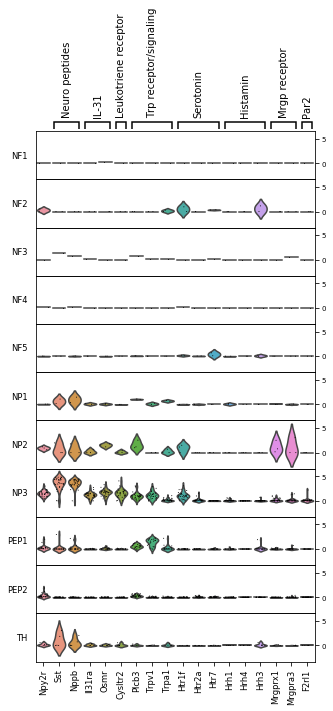

In [23]:
#Here we ads some decoration to our plot to explain gene functions
var_names = ["Npy2r",
             "Sst",
             "Nppb",
             "Il31ra",
             "Osmr",
             "Cysltr2",
             "Plcb3",
             "Trpv1",
             "Trpa1",
             "Htr1f",
             "Htr2a",
             "Htr7",
             "Hrh1",
             "Hrh4",
             "Hrh3",
             "Mrgprx1",
             "Mrgpra3",
             "F2rl1"
             ]
vgl = ["Neuro peptides",
       "IL-31",
       "Leukotriene receptor",
       "Trp receptor/signaling",
       "Serotonin",
       "Histamin",
       "Mrgp receptor",
       "Par2"
      ]
vgp = [(1,2),
       (3,4),
       (5,5),
       (6,8),
       (9,11),
       (12,14),
       (15,16),
       (17,17)
      ]
sc.pl.stacked_violin(y2, var_names=var_names, groupby="Level 3", stripplot=True, jitter=0.3, figsize=(5,10), var_group_labels=vgl, var_group_positions=vgp, save = "_Y2_all_cells.pdf")

Npy2r is expressed mostly in NP3 with high expression, and moderatly in PEP1 and PEP2. Expression is present in other cell types, but at a very low level.

Usoskin *et al* did investigate the modality of the different cell types, and PEP1 and PEP2 are mostly nociceptive. Further more, NP3 was concluded to be related to inflammatory itch. Here we select only the NP1-3 cells to focus the investigation on itch related neurons. Note that the PEP1 and PEP2 Npy2r expressing neurons could explain the phenotype seen by Arcote *et al*.


In [24]:
#Selects only NP1-3
select_cell_type = [True if celltype in ["NP1", "NP2", "NP3"] else False for celltype in merge.obs["Level 3"]]
#Selects only expression over 0.01
select_y2 = merge[:,merge.var_names == "Npy2r"].X > 0.01
#Both has to be true
select = np.logical_and(select_cell_type, select_y2)
#Creates new adata object with our cells
y2_NP = merge[select]

print(sum(y2_NP.obs["Level 3"] == "NP1"), " cells comes from NP1")
print(sum(y2_NP.obs["Level 3"] == "NP2"), " cells comes from NP2")
print(sum(y2_NP.obs["Level 3"] == "NP3"), " cells comes from NP3")

y2_NP

2  cells comes from NP1
3  cells comes from NP2
31  cells comes from NP3


View of AnnData object with n_obs × n_vars = 36 × 26581 
    obs: 'Content', 'Level 1', 'Level 2', 'Level 3', 'Library', 'Picking ToC', 'Picking sessions', 'Reads', 'Sex', 'batch', 'n_counts', 'Probability'
    uns: 'pca', 'batch_colors'
    obsm: 'X_pca'
    varm: 'PCs'

saving figure to file ./figures/stacked_violin_NP_cell types.pdf


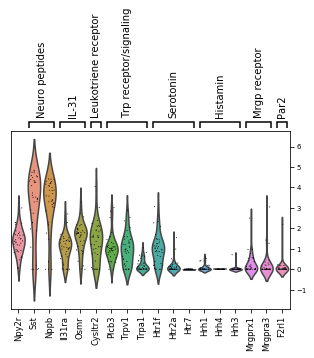

In [25]:
sc.pl.stacked_violin(y2_NP, var_names=var_names, stripplot=True, jitter=0.3,var_group_labels=vgl, var_group_positions=vgp, figsize=(5,3.5), save= "_NP_cell types.pdf")

Npy2r is coexpressed with Sst, Nppb, I31ra, Osmr, Cysltr2, TrpV1, Plcb and Htr1f in NP1-3 cells. 

# Differentially expressed genes
We have already seen that the Y2 neurons expresses many itch related genes, lets see the top 40 DE genes for these cells compared to the rest of all neurons in the datasets.

In [26]:
from pandas.api.types import CategoricalDtype

#maps new names onto the selection vector to make the naming prittier
y2dict = {True: "Y2", False: "Other"}
new_select = []
for cell in select:
    new_select.append(y2dict.get(cell))

merge.obs["Y2_NP"] = new_select
#store as categorical (should be done automatically by scanpy, but bugs...)
merge.obs["Y2_NP"] = merge.obs["Y2_NP"].astype(CategoricalDtype())


In [27]:
#compares only for the Y2 group agains other, we are not interested in the "other" agains the Y2
sc.tl.rank_genes_groups(merge, groupby="Y2_NP", groups = ["Y2"])

saving figure to file ./figures/matrixplot_Y2_NP specific genes.pdf


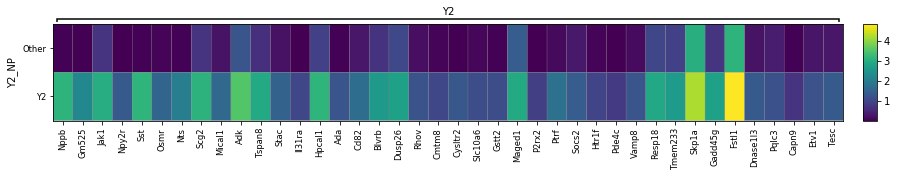

In [28]:
sc.pl.rank_genes_groups_matrixplot(merge, groupby="Y2_NP", n_genes=40, save= "_Y2_NP specific genes.pdf")

In this list, we recognize many of our itch related genes, but also many new interesting gens. 

In [42]:
#this function can calculate the percentage of cells that expresses a gene, given a adata object
def percent_expressing(adata, gene):
    ratio = len(adata[adata[:,gene].X > 0]) / len(adata.X)
    return ratio*100

#Here we investigate the percent of Y2 neurons that also express Sst and Nppb
print(percent_expressing(y2_NP, "Sst"), "% of Y2 neuron express Sst")
print(percent_expressing(y2_NP, "Nppb"), "% of Y2 neuron express Nppb")

91.66666666666666 % of Y2 neuron express Sst
91.66666666666666 % of Y2 neuron express Nppb


# Conclusion
In this analysis, we merge two datasets from different experiments in order to compare cells related to cell types, and not only gene expression levels. Merging success was confirmed as the cells clustered based on cell phenotype, and not on dataset origin. We then used a simple machine learning algorithm to deduce the cell types of Li cells based on the preexisting nomenclture from Usoskin. 

In order to compare gene expression levels between the datasets, we normalized the gene expression for each cell, which in theory should let us compare the gene level across the different datasets.

We found that the highest expression levels of Npy2r were found in the itch related cell type NP3, and that this population showed expression of many itch related genes that can illuminate the phenotype we have seen in behaiviour studies.

In [29]:
merge


AnnData object with n_obs × n_vars = 826 × 26581 
    obs: 'Content', 'Level 1', 'Level 2', 'Level 3', 'Library', 'Picking ToC', 'Picking sessions', 'Reads', 'Sex', 'batch', 'n_counts', 'Probability', 'Y2_NP'
    uns: 'pca', 'batch_colors', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs'